DATA PREPROCESSING

In [17]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import pandas as pd
import os
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
import seaborn as sns
import numpy as np
from pathlib import Path


user = 'omarlodhi'

figure_path = f'/Users/{user}/Downloads/UVAmacro-main/post_5/figures'


# Define the path to the directory containing the CSV files
data_path = Path(f'/Users/{user}/Downloads/UVAmacro-main/post_5/data')


df_OIS_swaps = pd.read_csv(f'{data_path}/OIS_swap_rates.csv')

df_treasury_yields = pd.read_csv(f'{data_path}/treasury_yields.csv')

df_tp = pd.read_csv(f'{data_path}/ACM.csv')

df_tp = df_tp[['Date', 'ACMTP10']]

df_tp.rename(columns={'ACMTP10': '10yr_tp'}, inplace=True)

df_tp['Date'] = pd.to_datetime(df_tp['Date'])

df_OIS_swaps['Date'] = pd.to_datetime(df_OIS_swaps['Date'])

df_OIS_swaps.loc[:, df_OIS_swaps.columns != "Date"] *= 1000


df_treasury_yields['Date'] = pd.to_datetime(df_treasury_yields['Date'])

df_total = pd.merge(df_OIS_swaps, df_treasury_yields, on='Date', how='inner')

df_total = pd.merge(df_total, df_tp, on='Date', how='inner')

df_total.rename(columns={'7yr_yield ': '7yr_yield'}, inplace=True)
df_total.sort_values(by='Date', ascending=True, inplace=True)
df_total.reset_index(drop=True, inplace=True)

df_total['10yr_tp'] = df_total['10yr_tp']*100

df_total['1y6m_OIS_swap'] = ((1+0.5*df_total['1yr_OIS_swap'] + 0.5*df_total['2yr_OIS_swap'])/(1+df_total['6m_OIS_swap'])**0.5)**2 - 1

df_total['1y1y_OIS_swap'] = ((1+df_total['2yr_OIS_swap'])**2/(1+df_total['1yr_OIS_swap'])) - 1

df_total['ffr_curve'] = (df_total['1y1y_OIS_swap'] - df_total['1yr_OIS_swap']) 

df_total['ffr_curve'] = df_total['ffr_curve'].abs()

df_total['aged'] = df_total['ffr_curve'].shift(90)



<Figure size 800x600 with 0 Axes>

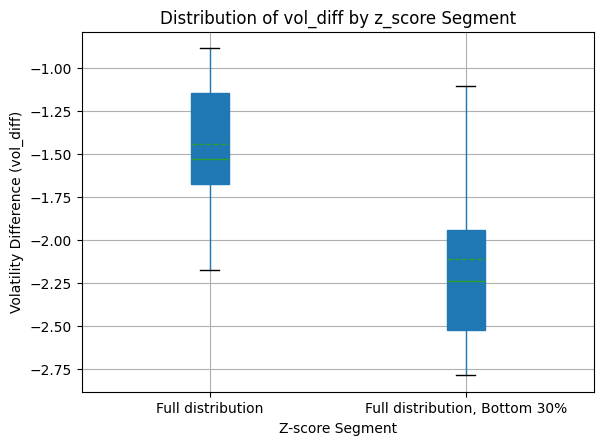

In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def plot_vol_diff_boxplot(df, date_col, ois_col, aged_col, start_date, end_date):
    """
    Computes realized volatilities (daily and bi-weekly), calculates vol_diff, segments based on z-score distribution, 
    and plots a boxplot of vol_diff for the Full distribution, Bottom 40%, and Bottom 20% z-score groups, 
    conditioned on the move_level being above a threshold.

    Parameters:
    df (pd.DataFrame): The input DataFrame containing relevant columns.
    date_col (str): The name of the date column.
    ois_col (str): The name of the 5-year OIS swap column.
    aged_col (str): The name of the aged variable for z-score calculation.
    move_level_col (str): The name of the move_level column.
    move_level_threshold (float): The threshold for filtering move_level.
    start_date (str): The start date for filtering observations (format: 'YYYY-MM-DD').

    Returns:
    None (Displays a boxplot)
    """

    df = df.copy()

    # Convert date column to datetime if not already
    df[date_col] = pd.to_datetime(df[date_col])

    # Filter data for the specified date range
    df = df[df[date_col] >= pd.to_datetime(start_date)]
    df = df[df[date_col] <= pd.to_datetime(end_date)]

    # Apply condition on move_level
    
    # Compute rolling realized volatilities
    df['RV_daily'] = df[ois_col].rolling(90).std()
    df['RV_biweekly'] = df[ois_col].rolling(90).apply(lambda x: np.std(x[::15]), raw=True) / np.sqrt(15)

    # Compute the difference in realized volatility
    df['vol_diff'] = df['RV_biweekly'] - df['RV_daily']

    # Compute z-score for 'aged' variable over a 252-day window
    df['rolling_mean'] = df[aged_col].rolling(252).mean()
    df['rolling_std'] = df[aged_col].rolling(252).std()
    df['z_score'] = (df[aged_col] - df['rolling_mean']) / df['rolling_std']

    # Compute quantiles for z-score segmentation
    quantiles = df['z_score'].quantile([0.20, 0.25, 0.3, 0.4, 1])

    # Assign segmentation categories using double storage
    df.loc[df['z_score'] <= quantiles[1], 'z_score_segment'] = 'Full distribution'
    df.loc[df['z_score'] <= quantiles[0.3], 'z_score_segment'] += ', Bottom 30%'


    # Create a boxplot for vol_diff grouped by z-score segments
    plt.figure(figsize=(8, 6))

    boxprops = dict(showfliers=False, showmeans=True, meanline=True)  # Hide outliers, show mean line

    df.boxplot(column='vol_diff', by='z_score_segment', patch_artist=True, **boxprops)
    
    plt.title('Distribution of vol_diff by z_score Segment')
    plt.xlabel('Z-score Segment')
    plt.ylabel('Volatility Difference (vol_diff)')
    plt.suptitle('')  # Remove default title from boxplot
    plt.show()

# Example usage: Apply the function with a threshold on `move_level`
plot_vol_diff_boxplot(df_total, 'Date', '5yr_OIS_swap', 'aged', '2023-01-01', '2024-11-20')


